In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

## Loading the Dataset

In [2]:
x = []
y = []
datadir = r'C:\Users\Korisnik\Desktop\Simple_CV_Calculator\data\dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['6', '9', 'mul', '0', '5', 'div', 'sub', '2', '8', '7', '1', 'add', '3', '4']


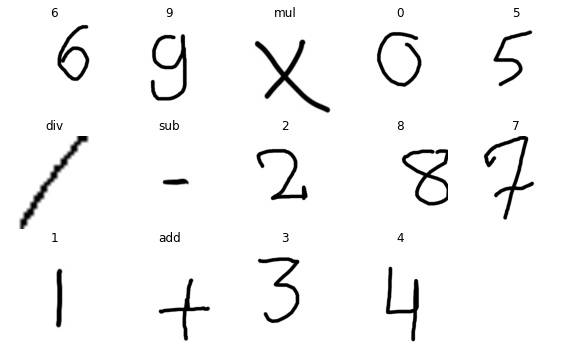

In [3]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Preprocessing the Data

In [4]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

## Defining the Model

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [8]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [9]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

## Training the Model

In [10]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [11]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
48/48 [==============================] - 7s 130ms/step - loss: 2.8917 - accuracy: 0.2355 - val_loss: 2.2383 - val_accuracy: 0.4882
Epoch 2/100
48/48 [==============================] - 6s 127ms/step - loss: 1.7089 - accuracy: 0.5727 - val_loss: 1.3633 - val_accuracy: 0.7211
Epoch 3/100
48/48 [==============================] - 6s 130ms/step - loss: 1.2054 - accuracy: 0.7015 - val_loss: 1.1942 - val_accuracy: 0.7283
Epoch 4/100
48/48 [==============================] - 7s 140ms/step - loss: 1.0037 - accuracy: 0.7604 - val_loss: 1.0536 - val_accuracy: 0.7684
Epoch 5/100
48/48 [==============================] - 7s 136ms/step - loss: 0.8368 - accuracy: 0.8018 - val_loss: 0.8379 - val_accuracy: 0.8237
Epoch 6/100
48/48 [==============================] - 6s 133ms/step - loss: 0.7537 - accuracy: 0.8255 - val_loss: 0.7154 - val_accuracy: 0.8638
Epoch 7/100
48/48 [==============================] - 6s 134ms/step - loss: 0.6775 - accuracy: 0.8459 - val_loss: 0.8873 - val_accuracy: 0.7987

## Loss and Accuracy Plot

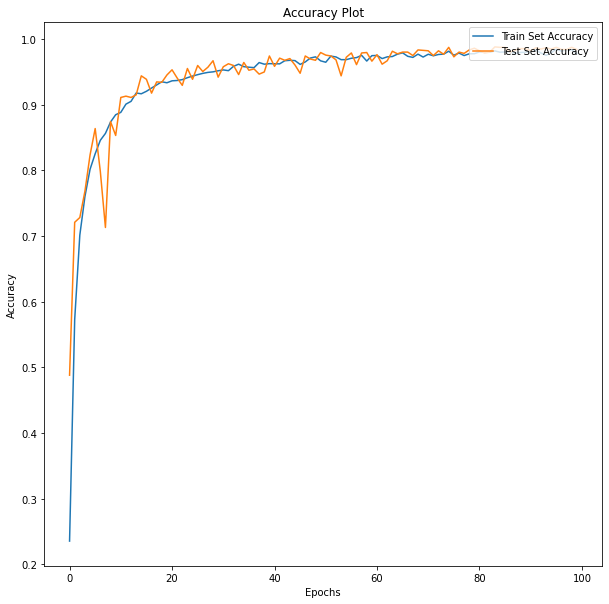

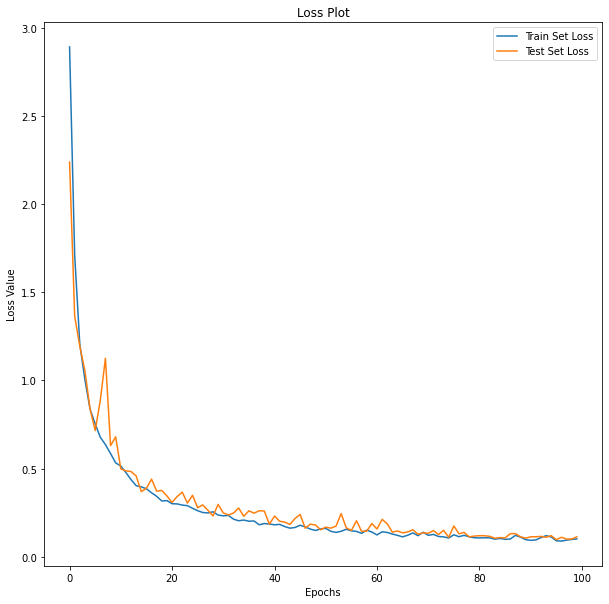

In [12]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Classification Report

In [13]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       116
           1       1.00      0.90      0.95       103
           2       0.99      0.99      0.99        95
           3       0.98      1.00      0.99        96
           4       0.98      0.97      0.98       109
           5       1.00      0.99      0.99        73
           6       0.98      0.99      0.99       120
           7       0.94      0.98      0.96       104
           8       0.97      0.99      0.98       117
           9       0.97      0.99      0.98       101
          10       0.99      0.99      0.99       113
          11       1.00      1.00      1.00       108
          12       1.00      0.99      1.00       113
          13       0.99      1.00      1.00       152

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.98      0.98      0.98      1520



## Confusion Matrix

<AxesSubplot:>

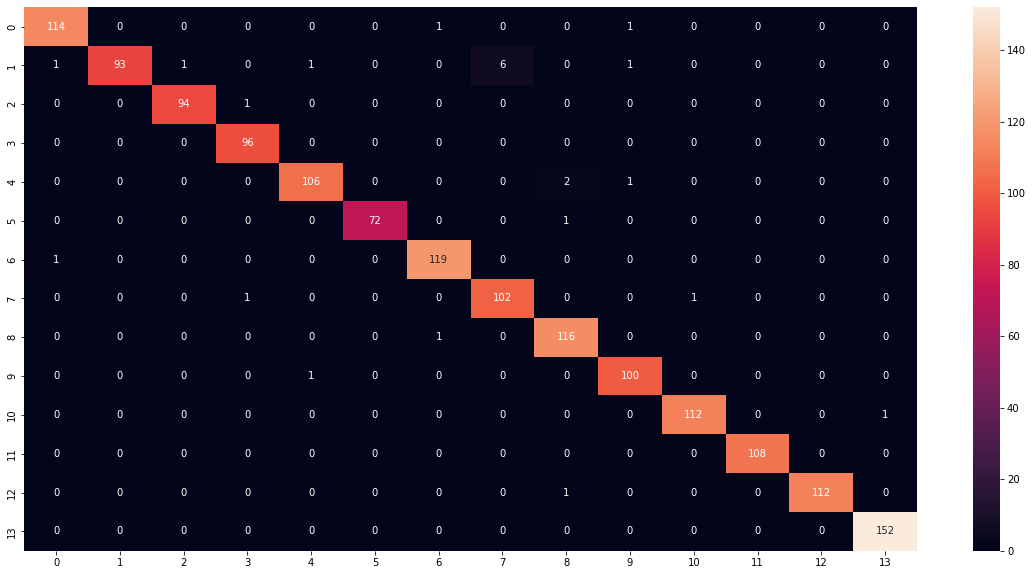

In [14]:
matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sn.heatmap(df_cm, annot=True, fmt='d')

## Saving the Model

In [15]:
model.save('maths_symbol_and_digit_recognition.h5')

## Testing the Model

In [16]:

import cv2
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

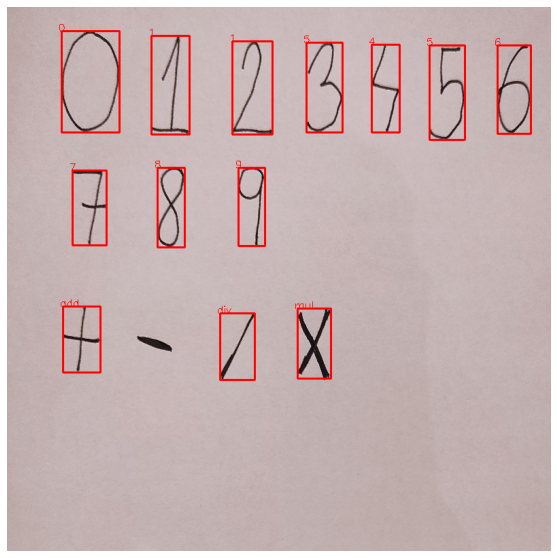

In [22]:
test_pipeline(r'C:\Users\Korisnik\Desktop\Simple_CV_Calculator\data\test.jpg')

## Pipeline for Expression Solving

In [19]:
from math import floor, trunc

def test_pipeline_equation(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
    #         print(pred)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
   
    e = ''
    
    
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i

    class Solution:
        def solve(self, s):
            s = list(s[::-1])

            def get_value():
                sign = 1
                if s and s[-1] == "-":
                    s.pop()
                    sign = -1
                value = 0
                while s and s[-1].isdigit():
                    value *= 10
                    value += int(s.pop())
                return sign * value

            def get_term():
                term = get_value()
                while s and s[-1] in "*/":
                    op = s.pop()
                    value = get_value()
                    if op == "*":
                        term *= value
                    else:
                        term = floor(1.0 * term / value)
                return term

            ans = get_term()
            while s:
                op, term = s.pop(), get_term()
                if op == "+":
                    ans += term
                else:
                    ans -= term
            return ans

    ob = Solution()
    s = e
    v = ob.solve(s)
    print('Value of the expression {} : {}'.format(e, v))

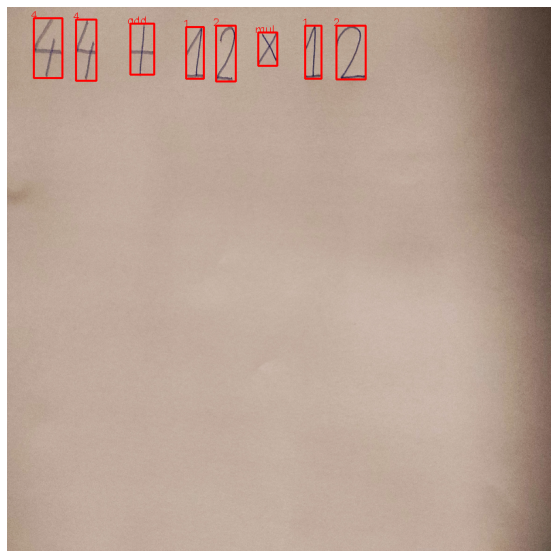

Value of the expression 44+12*12 : 188


In [21]:
test_pipeline_equation(r'C:\Users\Korisnik\Desktop\Simple_CV_Calculator\data\equation.jpg')